In [1]:
import netCDF4 as nc
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cmocean as cmo
import os,sys,fnmatch,time
import numpy as np
import matplotlib.gridspec as gridspec
from matplotlib import animation
from salishsea_tools.nc_tools import scDataset
from matplotlib import colors
from matplotlib import ticker
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1.inset_locator import InsetPosition
import matplotlib as mpl
import numpy.ma as ma
from scipy import interpolate
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches

%matplotlib inline

import sys
sys.path.append('/ocean/imachuca/Canyons/analysis_mackenzie_canyon/notebooks/upwelling_depth/')
import upwelling_functions
sys.path.append('/ocean/imachuca/Canyons/analysis_mackenzie_canyon/notebooks/general_circulation/')
import general_functions
import quicklook

import warnings
warnings.filterwarnings("ignore")

import time
from datetime import datetime 

/home/imachuca/anaconda3/lib/python3.6/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):


In [2]:
def get_varbs(kind, case, fname, meshmaskname, time_s):
    if fname == 'MCKNZ_1h*':
        y,x = slice(0,-2,None), slice(0,-2,None)
    elif fname == '1_MCKNZ_1h*':
        y,x = slice(0,-3,None), slice(3,-3,None)
    dirname = '/ocean/imachuca/Canyons/results_mackenzie/extended_domain/'+kind+'_'+case+'/'
    filesW = general_functions.get_files(dirname, fname, 'grid_W') 
    filesT = general_functions.get_files(dirname, fname, 'grid_T')
    with scDataset(filesW) as dsW, scDataset(filesT) as dsT:
        vovecrtz = dsW.variables['vovecrtz'][time_s, :, y, x] 
        vosaline = dsT.variables['vosaline'][time_s, :, y, x]
        depthw = dsW.variables['depthw'][:]
    with nc.Dataset(os.path.join(dirname, meshmaskname), 'r') as dsM:
        e1t0 = np.nanmean(dsM.variables['e1t'][0, y, x], axis=0)
        e2t0 = np.nanmean(dsM.variables['e2t'][0, y, x], axis=1)
        e1t = np.cumsum(e1t0) / 1000 # km
        e2t = np.cumsum(e2t0) / 1000 # km
    print(time_s)
    return vovecrtz, vosaline, e1t, e2t, depthw

In [3]:
bathy_c = nc.Dataset('/ocean/imachuca/Canyons/results_mackenzie/extended_domain/ideal_base/1_ideal_bathy_for_agrif.nc')['Bathymetry'][:-3, 3:-3]
bathy_p = nc.Dataset('/ocean/imachuca/Canyons/mackenzie_canyon/bathymetry/NEMO_files/idealized/ideal_bathy_for_agrif.nc')['Bathymetry'][:-2, :-2]
vosaline_ref = nc.Dataset('/ocean/imachuca/Canyons/mackenzie_canyon/conditions/NEMO_files/salinity/salinity_for_agrif.nc')['vosaline'][:]
vosaline_ref_profile = vosaline_ref[0, :, 0, 0]


In [4]:
def get_varb_surf(vosaline_array, salt, varb):
    
    if len(vosaline_array.shape)==1:
        f = interpolate.interp1d(vosaline_array, varb)
        ynew = f(salt)
        varb_array = ynew
        
    elif len(vosaline_array.shape)!=1:
        varb_array = np.full([vosaline_array.shape[-2], vosaline_array.shape[-1]], np.nan)
        for i in range(vosaline_array.shape[-1]):
            for j in range(vosaline_array.shape[-2]):
                vosaline_column = vosaline_array[:, j, i]
                if len(varb.shape)==1:
                    varb_column = varb
                elif len(varb.shape)==3:
                    varb_column = varb[:, j, i]

                try:
                    f = interpolate.interp1d(vosaline_column, varb_column)
                    ynew = f(salt)
                    varb_array[j, i] = ynew
                except ValueError:
                    varb_array[j, i] = np.nan  
                
    return varb_array

In [16]:
fs_numb, fs_str = 25, 30
fname = '1_MCKNZ_1h*'
meshmaskname = '1_mesh_mask.nc'
case = 'base'
kind = 'ideal'
salt_UHW_SA, salt_ATW_SA = 33.26258156425155, 34.99102991139694
salt = salt_UHW_SA

time_s = 20
vovecrtz, vosaline, e1t, e2t, depthw = get_varbs(kind, case, fname, meshmaskname, time_s)
w_surface = get_varb_surf(vosaline, salt, vovecrtz) * 1000
depth_initial = get_varb_surf(vosaline_ref_profile, salt, depthw)

20


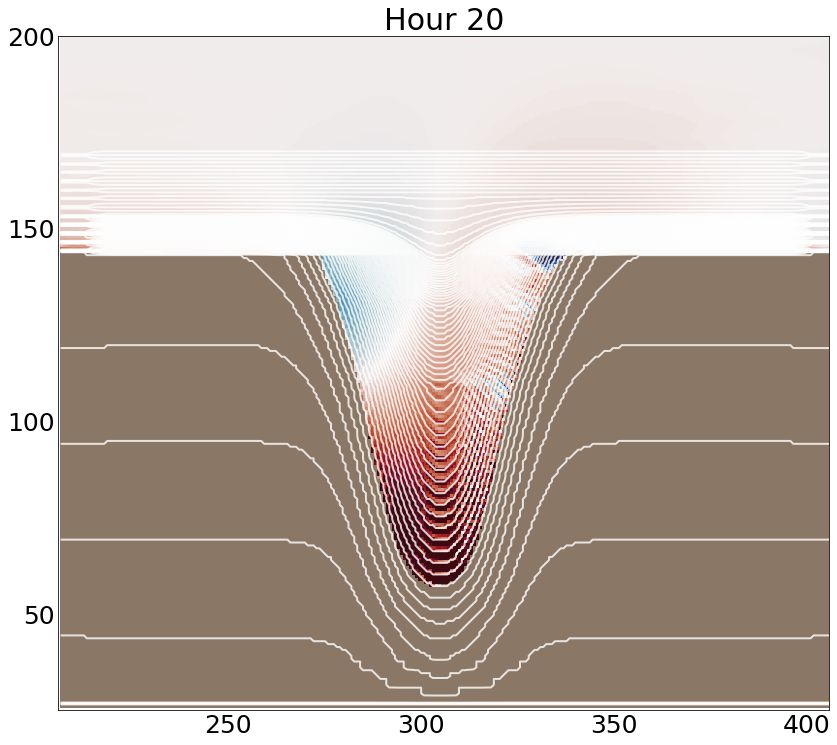

In [29]:
if kind == 'ideal':
    x_left, y_bottom = 205.822543591543,24.85159075988878
    inds = [90, 10]
    mid = 306
    ticklabs = np.arange(250,450,50)
elif kind == 'real':
    x_left, y_bottom = 296.29431501679437, 24.85159075988878
    inds = [130, 10]
    mid = 400
    ticklabs = np.arange(350,550,50)

x_shift, y_shift = x_left+e1t, y_bottom+e2t
vm = 1.2
cmap = cmo.cm.balance
cmap.set_bad('#8b7765')

fig, ax = plt.subplots(1,1,figsize=(20,10))

p = ax.pcolormesh(x_shift, y_shift, w_surface, vmin=-vm, vmax=vm, cmap=cmap)
ax.contour(x_shift, y_shift, bathy_c, levels=depthw[:], colors='w', alpha=0.8, linewidths=2, zorder=6)

min_x, max_x, min_y, max_y = mid-100, mid+100, 25, 200
ax.set_xlim([min_x, max_x])
ax.set_ylim([min_y, max_y])
ax.yaxis.set_ticks(np.arange(50, 250, 50))
ax.xaxis.set_ticks(ticklabs)

ax.tick_params(axis='both', which='both', length=0, labelsize=fs_numb)
ax.set_aspect(aspect='equal')
ax.set_title('Hour '+str(time_s), fontsize=fs_str)

fig.tight_layout()
fig.patch.set_facecolor('white')    
plt.subplots_adjust(top=0.99, wspace=0.1, hspace=0.05)
fig.savefig('./extra_steps.png', dpi=200, bbox_inches='tight', format='png', facecolor=fig.get_facecolor())